In [2]:
%load_ext autoreload
%autoreload 2

from qm.QuantumMachinesManager import QuantumMachinesManager
import numpy as np
import qm.qua as q
from opx_library import write_to_hdf5
from holzworth import HW
from queue_library import XQueue
import opx_config_TANT_opx1 as cf
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'opx_library'

In [54]:
from qm.QuantumMachinesManager import QuantumMachinesManager
import numpy as np
import qm.qua as q
from opx_library import write_to_hdf5
from holzworth import HW
from queue_library import XQueue
import opx_config_TANT_opx1 as cf
from importlib import reload
reload(cf)

with XQueue('Lior', QPU='Tant') as xq, HW('HW1') as hw:
    hw.set_ref_external_10MHz()
    hw.set_power_dbm(1, cf.pow_ch1_hw)
    hw.set_output_state(1, 1)
    hw.set_frequency(1, cf.lo_res)
    hw.set_power_dbm(4, cf.pow_pump_twpa)
    hw.set_output_state(4, 1)
    
    hw.set_frequency(4, cf.freq_pump_twpa)
    
    qmManager = QuantumMachinesManager()
    qmManager.reset_data_processing()
    qmManager.clear_all_job_results()
    qmManager.close_all_quantum_machines()

    cf.config['pulses']['meas_pulse_res']['length'] = 2000
    if_andrew01 = cf.config['elements']['andrew01']['intermediate_frequency'] - 0.06e6# + 0.25e6
    cf.config['elements']['andrew01']['intermediate_frequency'] = if_andrew01
    cf.config['mixers']['soda'][0]['intermediate_frequency'] = if_andrew01
    qm1 = qmManager.open_qm(cf.config)
    
   
    Navg=4000

    def reset_andrew01():
        Q = q.declare(q.fixed)
        q.measure('meas_op_res', 'res', None,\
          q.demod.full('integ_w_s', Q))
        
        with q.if_(Q > 0.0):
            q.play('pi_gauss_op_andrew01', 'andrew01')
    
    with q.program() as prog:    
        I = q.declare(q.fixed)  
        Q = q.declare(q.fixed)  
        n = q.declare(int)    
        duration = q.declare(int)
        stream_i = q.declare_stream()
        stream_q = q.declare_stream()
                
        rot_angle = 80*4*0.25e-3
        total_angle = q.declare(q.fixed, value=0)
        with q.for_(n, 0, n < Navg, n + 1):
            with q.for_(duration, 20, duration < 16000, duration + 80):
                reset_andrew01()
                q.reset_frame('andrew01')
                q.assign(total_angle, total_angle + rot_angle)
                q.play('pi_op_andrew01' * q.amp(0.5), 'andrew01')
                q.wait(duration, 'andrew01')
                q.frame_rotation_2pi(total_angle, "andrew01")
                q.play('pi_op_andrew01' * q.amp(0.5), 'andrew01')
                q.align('andrew01', 'res')
                q.measure('meas_op_res', 'res', None,\
                          q.demod.full('integ_w_c', I),\
                          q.demod.full('integ_w_s', Q))
                q.save(I, stream_i)
                q.save(Q, stream_q)  
                q.wait(100000, 'res')
    
        with q.stream_processing():
            stream_i.save_all('I')
            stream_q.save_all('Q')

    data_path="C:\\Users\\Scada-125\\Quantum Machines\\OPX Files\\"\
              "Users\\Lior\\Data\\Cooldown_20201115\\Tantalum"
    fname="ramsey_1d_1"
    
    job = qm1.execute(prog, data_limit=int(1e9), duration_limit=0,\
                      force_execution=True)
    new_path = write_to_hdf5(fname, data_path, job, prog, cf.config,\
                             queue=xq, force_increment=True, interval=2,\
                             print_tree=False)



<<< Current queue for Tant >>>
-----------------------------------------------------------------------------------------------
Start                    User                     UUID
-----------------------------------------------------------------------------------------------
[20201213]06:34:40       Lior                     ffe324c8-9439-4891-9991-7bc94629c8e9



You are done waiting.

2020-12-13 06:34:40,836 - qm - INFO - Performing health check
2020-12-13 06:34:40,838 - qm - INFO - Health check passed
2020-12-13 06:34:41,292 - qm - INFO - Flags: 
2020-12-13 06:34:41,293 - qm - INFO - Executing high level program

Creating file "C:\Users\Scada-125\Quantum Machines\OPX Files\Users\Lior\Data\Cooldown_20201115\Tantalum\20201213\ramsey_1d_16.hdf5" instead

Measurement progress: [==========] 100% of 1.6e+06 countable saves.                                                   
Done running!

Current disk usage:
---------------------
Total: 921 GB
Used: 852 GB
Free: 69 GB

Returning data p

In [ ]:
4*tw*f=p

In [19]:
2*np.pi*80*4*0.25e-3

0.5026548245743669

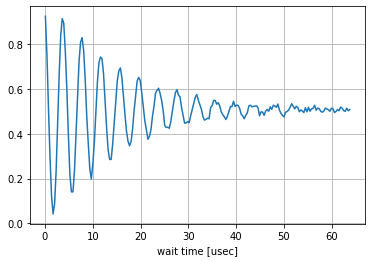

In [55]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

with h5py.File(new_path,'r') as datfile:
    dur = datfile['OPX_data/ind_arrays/array_1'][:]
    ii = datfile['OPX_data/output_arrays/I/value'][:]
    qq = datfile['OPX_data/output_arrays/Q/value'][:]
    i_avg = datfile['OPX_data/output_arrays/I/value'][:].reshape((Navg,  -1)).mean(axis=0)
    q_avg = datfile['OPX_data/output_arrays/Q/value'][:].reshape((Navg, -1)).mean(axis=0)
    phase = np.arctan2(i_avg, q_avg)
    disc = np.mean(qq.reshape((Navg, -1)) > 0.000, axis=0)

plt.plot(dur * 4 * 1e-3, disc)
plt.xlabel('wait time [usec]')
plt.grid()

In [56]:
dur_fake_detune = dur * 4 * 1e-3
disc_fake_detune = disc

In [52]:
dur_real_detune = dur * 4 * 1e-3
disc_real_detune = disc

In [58]:
np.savez("fake_rotation_vs_real_rotation", dur_fake_detune=dur_fake_detune, dur_real_detune=dur_real_detune, disc_fake_detune=disc_fake_detune, disc_real_detune=disc_real_detune)

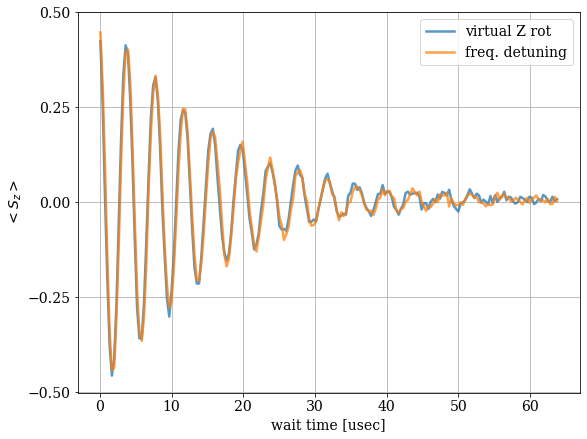

In [72]:
import matplotlib
matplotlib.rc('font', size=14, family='serif')
plt.figure(figsize=(9,7))
plt.plot(dur_fake_detune, disc_fake_detune - 0.5, label="virtual Z rot", linewidth=2.5, alpha=0.75)
plt.xlabel('wait time [usec]')
plt.plot(dur_real_detune, disc_real_detune - 0.5, label="freq. detuning", linewidth=2.5, alpha=0.75)
plt.xlabel('wait time [usec]')
plt.yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
plt.grid()
plt.ylabel(r'$<S_z>$')
plt.legend()

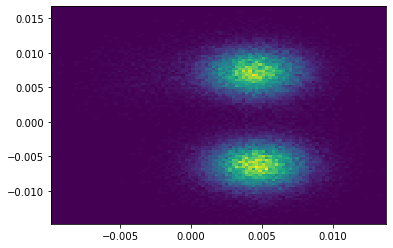

In [43]:
plt.hist2d(ii, qq, bins=100);

In [9]:
list(rot_dat.keys())

['dur_fake_detune', 'dur_real_detune', 'disc_fake_detune', 'disc_real_detune']

In [4]:
rot_dat = np.load('fake_rotation_vs_real_rotation.npz')

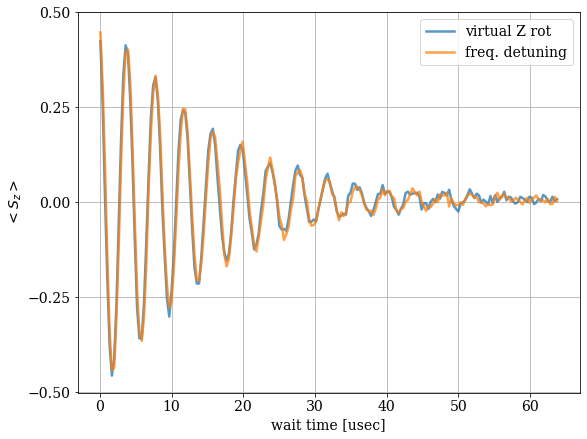

In [12]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rc('font', size=14, family='serif')
plt.figure(figsize=(9,7))
plt.plot(rot_dat['dur_fake_detune'], rot_dat['disc_fake_detune'] - 0.5, label="virtual Z rot", linewidth=2.5, alpha=0.75)
plt.xlabel('wait time [usec]')
plt.plot(rot_dat['dur_real_detune'], rot_dat['disc_real_detune'] - 0.5, label="freq. detuning", linewidth=2.5, alpha=0.75)
plt.xlabel('wait time [usec]')
plt.yticks([-0.5, -0.25, 0.0, 0.25, 0.5])
plt.grid()
plt.ylabel(r'$<S_z>$')
plt.legend()
from io import BytesIO
f = BytesIO();
plt.savefig("fake_vs_real_rot", format="svg")